In [1]:
import glob
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("max_colwidth", 100)
sns.set(rc={"figure.figsize": (30, 14)})

In [2]:
files_list = glob.glob("./results/bbcnews/*.json")
dfs = []
for f in files_list:
    embedding_retrieval_type = "_".join(f.split("_")[3:-1]) + "_pooling"
    df = pd.read_json(f)
    df["embedding_retrieval_type"] = embedding_retrieval_type
    dfs.append(df)

In [3]:
full_results = pd.concat(dfs)

In [5]:
keys_to_extract = ["embedding_model", "nr_topics", "min_topic_size"]
for key in keys_to_extract:
    full_results[key] = full_results["Params"].apply(lambda x: x.get(key, None))
full_results.drop("Params", axis=1, inplace=True)

In [6]:
keys_to_extract = ["npmi", "diversity"]
for key in keys_to_extract:
    full_results[key] = full_results["Scores"].apply(lambda x: x.get(key, None))
full_results.drop("Scores", axis=1, inplace=True)

In [7]:
results_grouped = full_results.groupby(
    [full_results["embedding_retrieval_type"], full_results["nr_topics"]], as_index=False
)[["nr_topics", "npmi", "diversity", "Computation Time"]].mean()

In [8]:
def rename_embedding_type(name):
    # Split the name into parts
    parts = name.split("_")

    # Define the new names for each part
    new_name_parts = {
        "concat": "Concat",
        "sum": "Sum",
        "last": "Last",
        "second": "Second",
        "all": "All",
        "four": "Four",
        "layers": "Layers",
        "layer": "Layer",
        "output": "Output",
        "hidden": "Hidden",
    }

    # Determine the pooling type and place it in parentheses
    pooling = parts[-2].upper() if parts[-2] == "cls" else parts[-2].capitalize()
    pooling_type = f"({pooling} Pooling)"

    # Check for 'embedding_layer' to include "Embedding Layer" in the new name
    if "_".join(parts[:2]) == "embedding_layer":
        new_name = "Embedding Layer " + " ".join(
            new_name_parts.get(part, part.capitalize()) for part in parts[2:-2]
        )
    else:
        new_name = " ".join(new_name_parts.get(part, part.capitalize()) for part in parts[1:-2])

    # Add the pooling type
    new_name += " " + pooling_type

    # Remove extra spaces and return
    return " ".join(new_name.split())

In [9]:
results_grouped["embedding_retrieval_type"] = [rename_embedding_type(name) for name in results_grouped["embedding_retrieval_type"]]

In [10]:
results_sorted_npmi = (
    results_grouped.groupby("embedding_retrieval_type")
    .mean("npmi")
    .reset_index()
    .sort_values("npmi", ascending=False)
)
top_categories_npmi = results_sorted_npmi.head(5)["embedding_retrieval_type"].tolist()

In [11]:
results_sorted_npmi

,embedding_retrieval_type,nr_topics,npmi,diversity,Computation Time
4,Embedding Layer Output (Max Pooling),30.0,0.192075,0.875000,13.980324
12,Sum All Layers (CLS Pooling),30.0,0.189032,0.852778,13.787363
7,Last Hidden Layer (Max Pooling),30.0,0.177788,0.895294,13.687794
10,Second Last Layer (Max Pooling),30.0,0.175939,0.857193,13.933847
13,Sum All Layers (Max Pooling),30.0,0.175415,0.840000,14.051110
2,Concat Last Four Layers (Mean Pooling),30.0,0.172317,0.872778,23.755192
11,Second Last Layer (Mean Pooling),30.0,0.171734,0.831038,13.749787
17,Sum Last Four Layers (Mean Pooling),30.0,0.170446,0.857222,13.612793
6,Last Hidden Layer (CLS Pooling),30.0,0.170226,0.848262,13.735227
9,Second Last Layer (CLS Pooling),30.0,0.168698,0.798480,13.720690


In [11]:
results_sorted_diversity = (
    results_grouped.groupby("embedding_retrieval_type")
    .mean("diversity")
    .reset_index()
    .sort_values("diversity", ascending=False)
)
results_sorted_diversity = results_sorted_diversity[results_sorted_diversity["embedding_retrieval_type"] != "Last Hidden Layer (CLS Pooling)"]
top_categories_diversity = results_sorted_diversity.head(5)["embedding_retrieval_type"].tolist()

In [16]:
top_categories_diversity

['Concat Last Four Layers (CLS Pooling)',
 'Concat Last Four Layers (Max Pooling)',
 'Last Hidden Layer (Max Pooling)',
 'Embedding Layer Output (Mean Pooling)',
 'Sum All Layers (Mean Pooling)']

In [20]:
default_setting = results_grouped[
    results_grouped["embedding_retrieval_type"] == "Last Hidden Layer (Mean Pooling)"
]

results_grouped = results_grouped[
    results_grouped["embedding_retrieval_type"] != "Last Hidden Layer (Mean Pooling)"
]

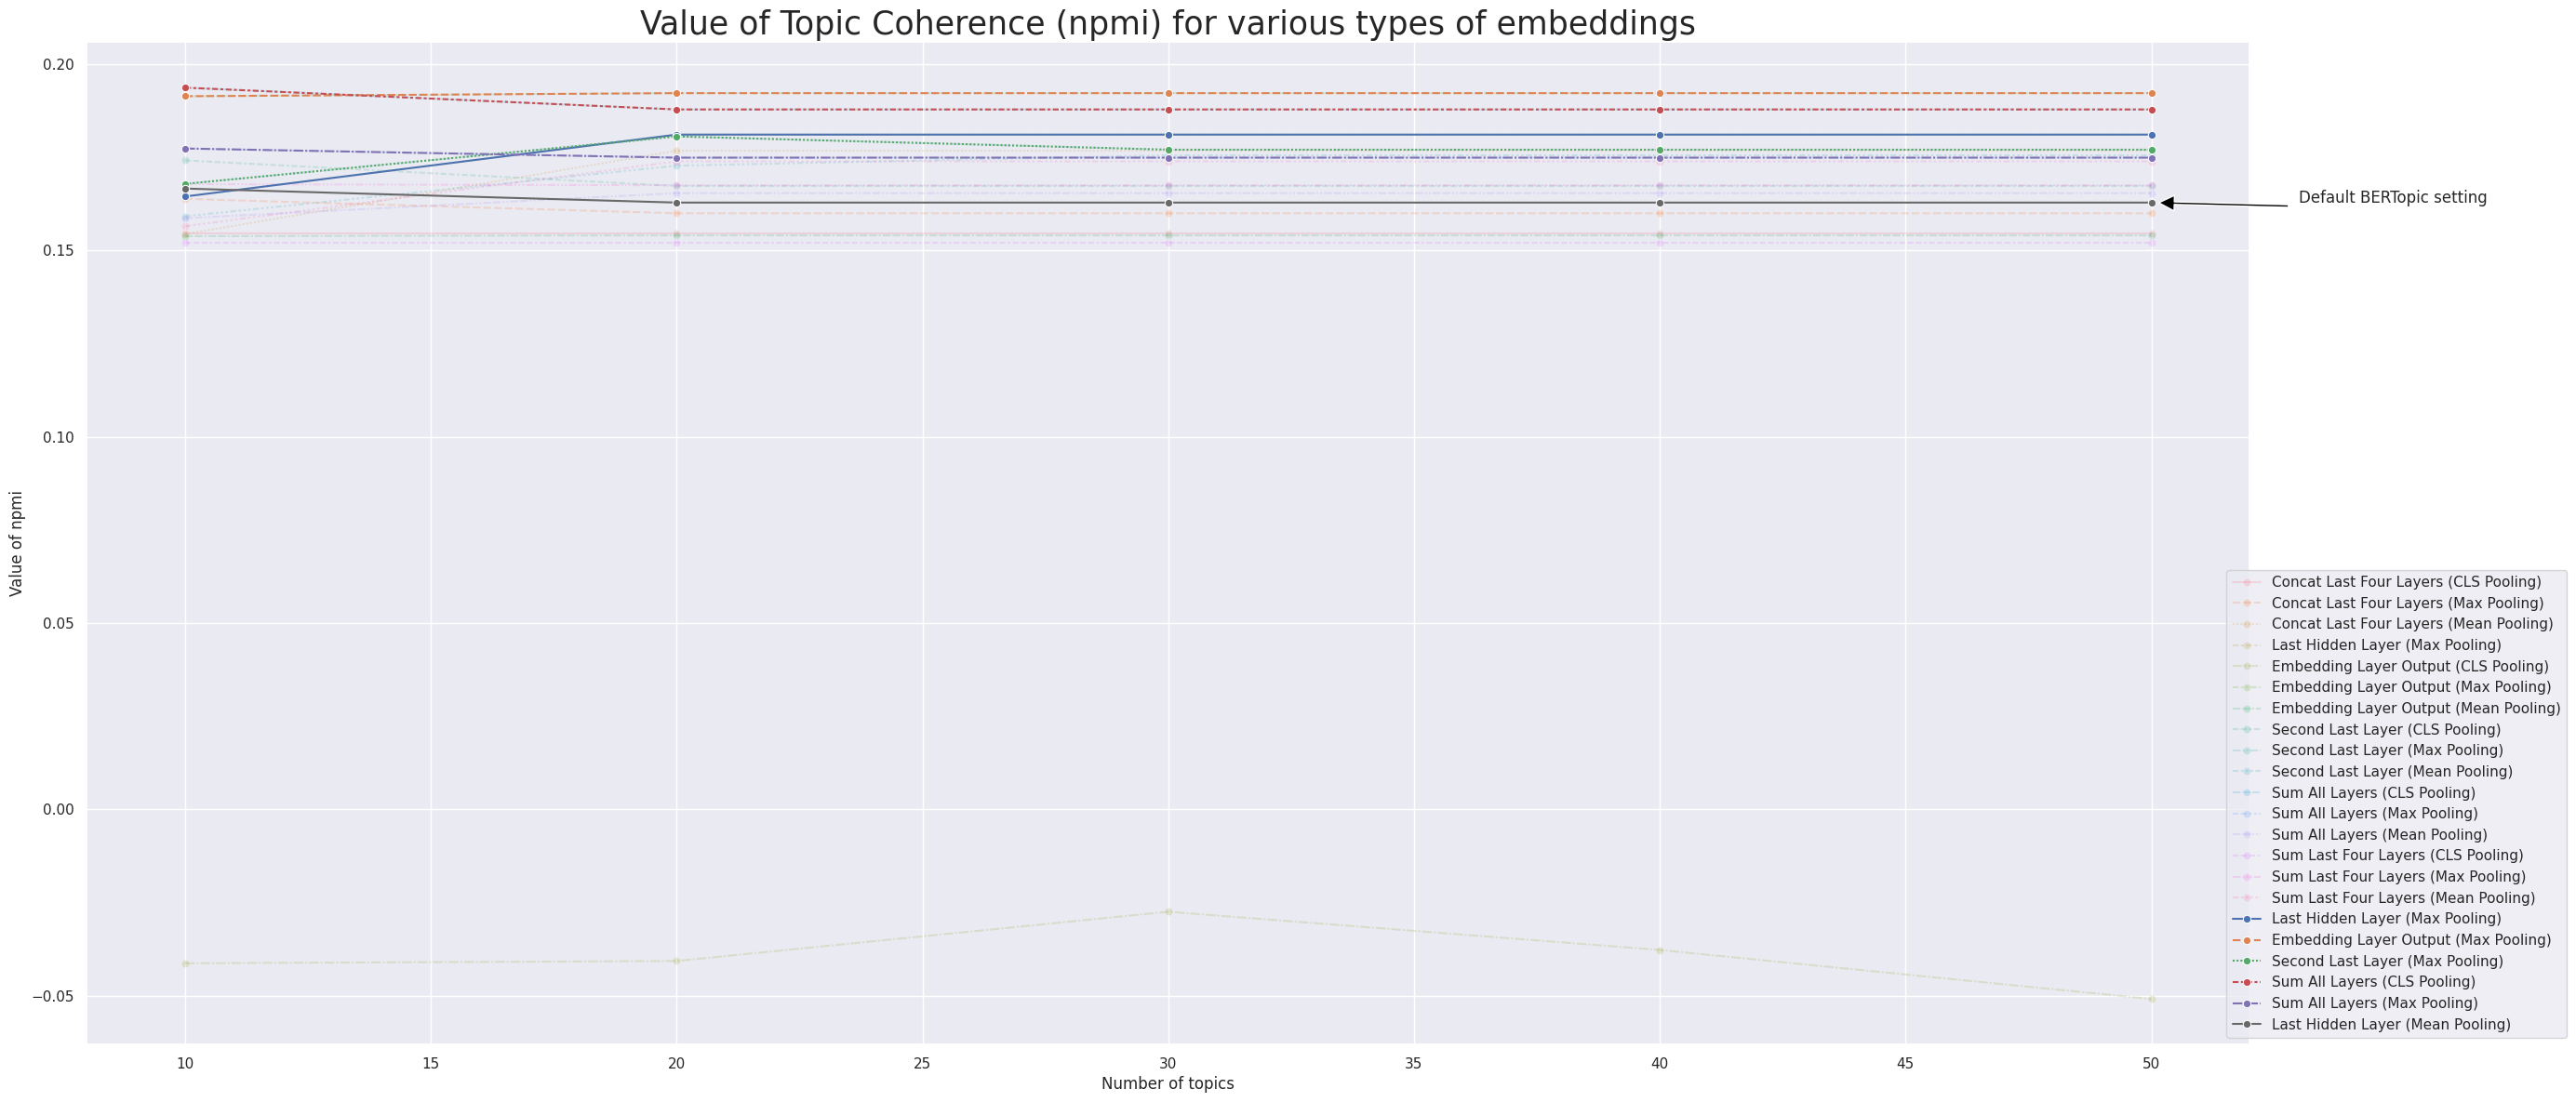

In [21]:
fig, ax = plt.subplots()
sns.lineplot(
    data=results_grouped,
    x="nr_topics",
    y="npmi",
    style="embedding_retrieval_type",
    hue="embedding_retrieval_type",
    alpha=0.2,
    marker="o",
    ax=ax,
)
sns.lineplot(
    data=results_grouped[results_grouped["embedding_retrieval_type"].isin(top_categories_npmi)],
    x="nr_topics",
    y="npmi",
    style="embedding_retrieval_type",
    hue="embedding_retrieval_type",
    alpha=1,
    marker="o",
    ax=ax,
)

sns.lineplot(
    data=default_setting,
    x="nr_topics",
    y="npmi",
    style="embedding_retrieval_type",
    color="dimgrey",
    alpha=1,
    marker="o",
    ax=ax,
)
plt.xlabel("Number of topics")
plt.ylabel("Value of npmi")
plt.title("Value of Topic Coherence (npmi) for various types of embeddings", size=25)

line = ax.lines[-2]
x_data = line.get_xdata()
y_data = line.get_ydata()
x_to_annotate = x_data[-1]
y_to_annotate = y_data[-1]

ax.annotate(
    "Default BERTopic setting",
    xy=(x_to_annotate, y_to_annotate),
    xytext=(x_to_annotate + 3, y_to_annotate),
    arrowprops=dict(facecolor="black", shrink=0.05, width=2),
)

ax.legend(loc="lower right", bbox_to_anchor=(1.15, 0))
plt.show()

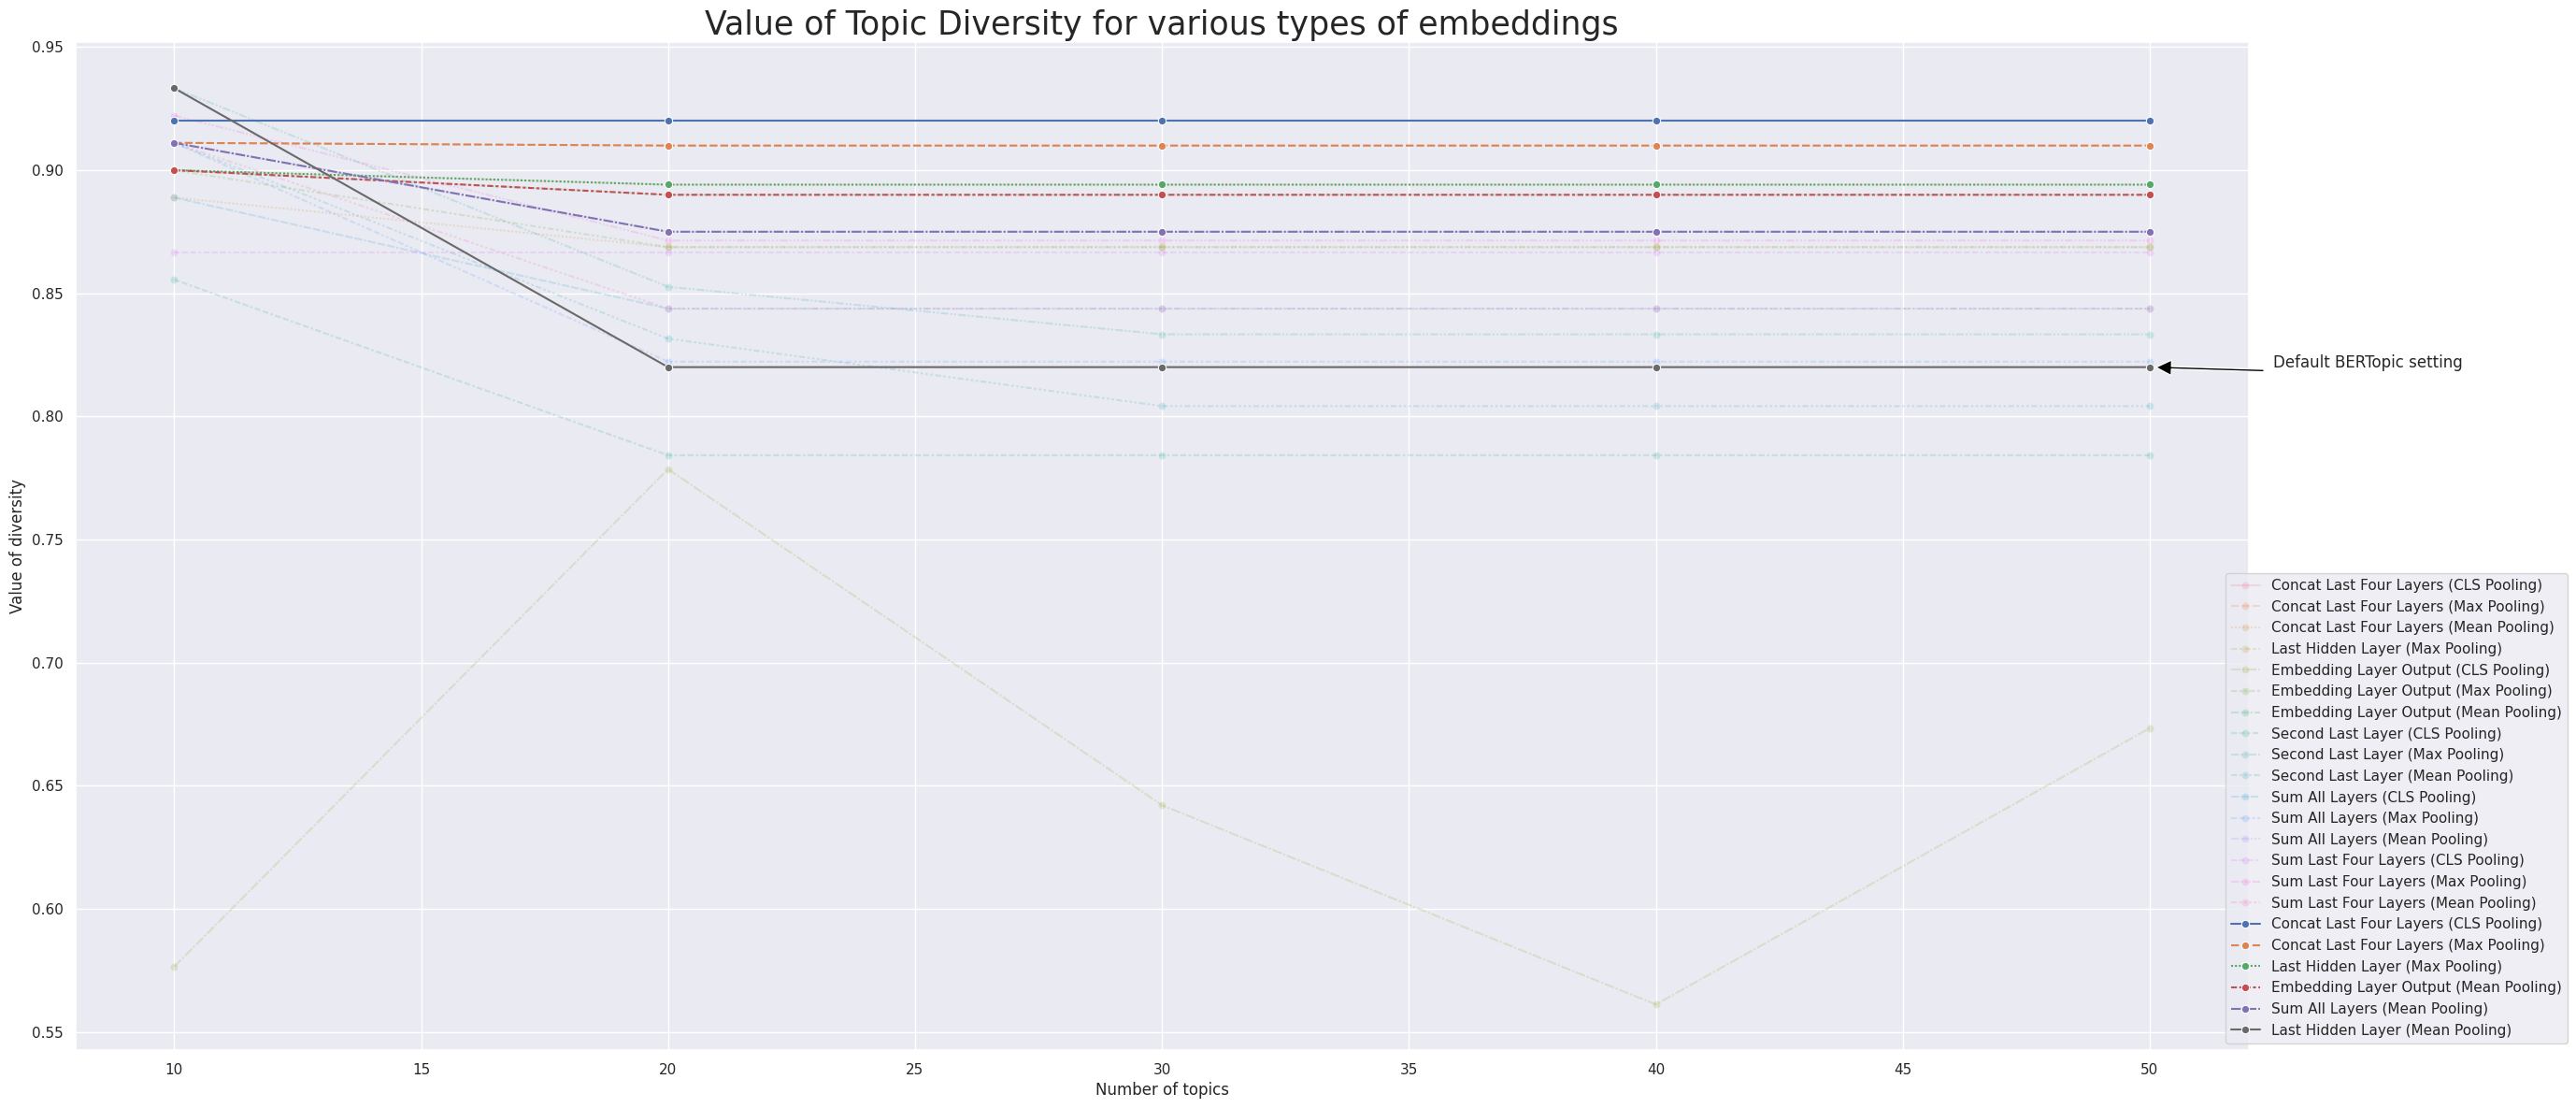

In [22]:
fig, ax = plt.subplots()
sns.lineplot(
    data=results_grouped,
    x="nr_topics",
    y="diversity",
    style="embedding_retrieval_type",
    hue="embedding_retrieval_type",
    alpha=0.2,
    marker="o",
    ax=ax,
)
sns.lineplot(
    data=results_grouped[results_grouped["embedding_retrieval_type"].isin(top_categories_diversity)],
    x="nr_topics",
    y="diversity",
    style="embedding_retrieval_type",
    hue="embedding_retrieval_type",
    alpha=1,
    marker="o",
    ax=ax,
)

sns.lineplot(
    data=default_setting,
    x="nr_topics",
    y="diversity",
    style="embedding_retrieval_type",
    color="dimgrey",
    alpha=1,
    marker="o",
    ax=ax,
)
plt.xlabel("Number of topics")
plt.ylabel("Value of diversity")
plt.title("Value of Topic Diversity for various types of embeddings", size=25)

line = ax.lines[-2]
x_data = line.get_xdata()
y_data = line.get_ydata()
x_to_annotate = x_data[-1]
y_to_annotate = y_data[-1]

ax.annotate(
    "Default BERTopic setting",
    xy=(x_to_annotate, y_to_annotate),
    xytext=(x_to_annotate + 2.5, y_to_annotate),
    arrowprops=dict(facecolor="black", shrink=0.05, width=2),
)

ax.legend(loc="lower right", bbox_to_anchor=(1.15, 0))
plt.show()